In [250]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

import seaborn as sns 

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

from utils import * 

label_size = 8
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
%matplotlib inline 

In [251]:
# will do the prediction for all counties which have a number greater than 10 in 2010 - sufficiently long enough baseline

df = pd.read_csv('../data/processed/alldata.csv')
df['FIPS'] = df['FIPS'].apply(lambda x: str(x).zfill(5))

# remove the last two years from MA 

df = df.drop(df[(df.Stname=='Massachusetts') & (df.year>2015)].index)
list_val_counties = df[(df.Cases>10) & (df.YR==2010)].FIPS.unique()
val_df = df[df['FIPS'].isin(list_val_counties)]

imp_cols = ['FIPS', 'Ctyname', 'Stname', 'STCODE', 'CTYCODE', 'Cases', 'CENSUSAREA',
       'geometry', 'year', 'Forest & Woodland','Cases_new', 'long', 'lat', 'counties',
       'TOT_POP', 'POP_URBAN', 'POPPCT_URBAN',  'AREA_URBAN', 'AREAPCT_URBAN', 'POP_RURAL', 'POPPCT_RURAL',
       'AREA_RURAL', 'AREAPCT_RURAL', 'Cases_norm', 'tavg', 'tmax', 'tmin', 'pcpn']

stat_cols = ['FIPS', 'Ctyname', 'Stname', 'STCODE', 'CTYCODE', 'geometry', 'lat', 'Forest & Woodland','POPPCT_URBAN','POPPCT_RURAL', 
                'AREAPCT_URBAN','AREAPCT_RURAL']

val_df = val_df[imp_cols]
xval_df = df[~df['FIPS'].isin(list_val_counties)][imp_cols]

val_df = val_df.drop(val_df[(val_df.FIPS=='25019')].index) # dropping nantucket 
xval_df = xval_df.drop(xval_df[(xval_df.FIPS=='25019')].index) # dropping nantucket 

cases_2010 = val_df[val_df['year']==2010][['FIPS', 'Cases_new']]
cases_2010.columns = ['FIPS', 'Cases2010']
val_df_norms = val_df.merge(cases_2010, on='FIPS', how='left')
val_df_norms['Cases_norm_2010'] = val_df_norms['Cases_new']/val_df_norms['Cases2010']

val_df.to_csv('../data/processed/fitting_df.csv')

## loading climate projections 
#clim_proj = load_clim_proj()

clim_proj_all = load_clim_proj_all()
clim_proj_all[clim_proj_all.isna().any(axis=1)]

,FIPS,tavg,tmax,tmin,pcpn,year


In [252]:
weather = pd.read_csv('../data/interim/weather.csv')
weather = weather_mean(weather)[['YR', 'ST', 'DIV', 'tavg', 'pcpn', 'tmax', 'tmin']]
weather.columns = ['year', 'ST', 'DIV', 'tavg', 'pcpn', 'tmax', 'tmin']

weather['ST_new'] = weather.ST.apply(lambda x: str(x).zfill(2))
weather['CT_new'] = weather.DIV.apply(lambda x: str(x).zfill(3))
weather['FIPS'] = weather.ST_new + weather.CT_new

In [253]:
statdf = val_df[stat_cols].drop_duplicates()
xstatdf = xval_df[stat_cols].drop_duplicates()

fips_all = statdf['FIPS'].unique()
slopes = []

for i in range(len(fips_all)): 
    fip = fips_all[i]
    temp = val_df[val_df['FIPS']==fip]
    years = temp[['year']].values[4:-2]
    cases = temp[['Cases']].values[4:-2]
    reg = LinearRegression().fit(years,cases)
    slopes.append(reg.coef_[0][0])
    
statdf['Slopes'] = slopes
xstatdf['Slopes'] = 0 

allstatdf = statdf.append(xstatdf)

allstatdf.to_csv('../data/processed/allstatdf.csv')

## Clustering and EDA 

- why this form of clustering? What does the clustering mean? Here is where we should bring in hierarchical time series forecasting  
- To reduce the dimensionality, also add as features the number of months that its warm and wet,or that the average temp is > 45 degrees and its not dry i.e. precipipation is not 0. 



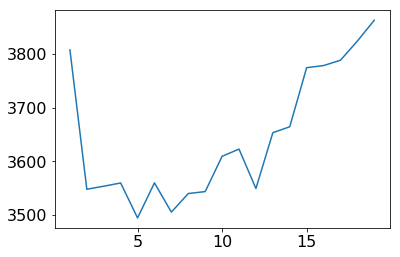

In [254]:
cluster_df = statdf.drop_duplicates()
X = np.array(cluster_df[['lat','Slopes','Forest & Woodland']])

bics =[]
for nclusters in range(1,20): 
    
    gmclusts = GaussianMixture(n_components=nclusters)
    gmclusts.fit(X)
    bic = gmclusts.bic(X)
    bics.append(bic)

plt.plot(range(1,20), bics)

In [255]:
# 4 clusters is the winner! 

In [256]:
nclusters = 4

cluster_df = statdf.drop_duplicates()
X = np.array(cluster_df[['lat','Slopes','Forest & Woodland']])
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)
cluster_df['Label'] = y_kmeans

fips_classes = []

val_df_norms.Label = 0 

for i in range(nclusters): 
    fips_classes.append(cluster_df[cluster_df['Label']==i]['FIPS'])
    mask = val_df_norms['FIPS'].isin(fips_classes[i])
    val_df_norms.loc[mask, 'Label'] = i


In [257]:
imp_indxs = np.argsort([len(x) for x in fips_classes])[-2:]
nonimp_indxs = np.argsort([len(x) for x in fips_classes])[0:2]

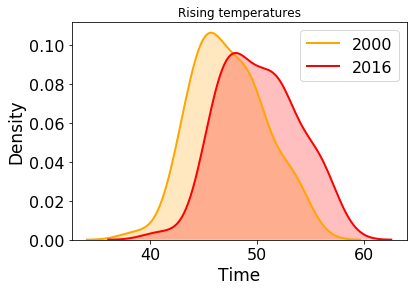

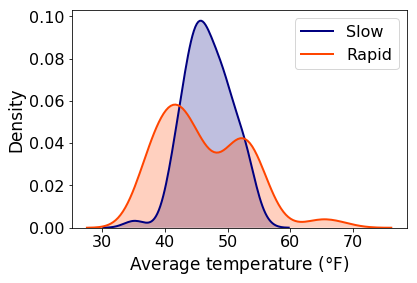

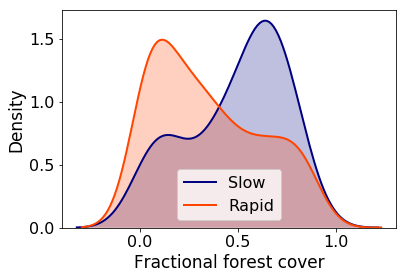

In [258]:
counties_class = val_df_norms[['FIPS', 'Label']].drop_duplicates()

counties_labels_all = val_df.set_index('FIPS').join(counties_class.set_index('FIPS')).reset_index()

xx = counties_labels_all[(counties_labels_all['Label']==imp_indxs[0]) & (counties_labels_all['year']==2000)]
yy = counties_labels_all[(counties_labels_all['Label']==imp_indxs[0]) & (counties_labels_all['year']==2016)]

plt.figure()
sns.distplot(xx.tavg.drop_duplicates(), hist=False, kde=True, color='orange', kde_kws = {'shade': True, 'linewidth': 2}, label='2000')
sns.distplot(yy.tavg.drop_duplicates(), hist=False, kde=True, color='red', kde_kws = {'shade': True, 'linewidth': 2}, label='2016')
plt.legend(prop={'size': 16})
plt.title('Rising temperatures')
plt.xlabel('Time', size=17)
plt.ylabel('Density', size=17)
plt.savefig('../reports/images/clim_change.jpeg', format='jpeg', dpi=200)

############ Tavg #################

xx = counties_labels_all[(counties_labels_all['Label']==imp_indxs[0]) & (counties_labels_all['year']==2014)]
yy = counties_labels_all[(counties_labels_all['Label']==imp_indxs[1]) & (counties_labels_all['year']==2014)]

plt.figure()
sns.distplot(xx.tavg.drop_duplicates(), hist=False, kde=True, color='navy', kde_kws = {'shade': True, 'linewidth': 2}, label='Slow')
sns.distplot(yy.tavg.drop_duplicates(), hist=False, kde=True, color='orangered', kde_kws = {'shade': True, 'linewidth': 2}, label='Rapid')
plt.legend(prop={'size': 16})
plt.xlabel('Average temperature ($\degree$F)', size=17)
plt.ylabel('Density', size=17)
plt.savefig('../reports/images/temp.jpeg', format='jpeg', dpi=200)

############ Forest_cover #################

xx = counties_labels_all[counties_labels_all['Label']==imp_indxs[0]]['Forest & Woodland'].drop_duplicates()
yy = counties_labels_all[counties_labels_all['Label']==imp_indxs[1]]['Forest & Woodland'].drop_duplicates()

plt.figure()
sns.distplot(xx, hist=False, kde=True, color='navy', kde_kws = {'shade': True, 'linewidth': 2}, label='Slow')
sns.distplot(yy, hist=False, kde=True, color='orangered', kde_kws = {'shade': True, 'linewidth': 2}, label='Rapid')
plt.legend(prop={'size': 16})
plt.xlabel('Fractional forest cover', size=17)
plt.ylabel('Density', size=17)
plt.savefig('../reports/images/forest.jpeg', format='jpeg', dpi=200)

In [259]:
class1 = counties_labels_all[counties_labels_all['Label']==1][['Cases', 'lat', 'tavg', 'tmin', 'tmax','pcpn']]
class3 = counties_labels_all[counties_labels_all['Label']==3][['Cases', 'lat', 'tavg', 'tmin', 'tmax','pcpn']]

class1.describe()

,Cases,lat,tavg,tmin,tmax,pcpn
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,527.744444,40.980000,51.564352,41.397963,61.722315,3.987537
std,309.208143,0.766826,2.555606,2.676706,2.508884,0.647667
min,67.000000,39.973000,46.275000,35.875000,56.483333,2.761667
25%,339.750000,40.212000,49.666667,39.127083,59.881250,3.518333
50%,457.500000,41.161000,52.016667,42.245833,61.808333,3.927083
75%,653.500000,41.763000,53.627083,43.550000,64.008333,4.318958
max,1720.000000,41.791000,55.633333,45.450000,66.275000,5.984167


In [260]:
class3.describe()

,Cases,lat,tavg,tmin,tmax,pcpn
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,265.438776,41.789605,49.608503,39.596854,59.612500,3.929076
std,218.910024,0.980216,2.156157,2.425414,2.053772,0.576230
min,0.000000,40.309000,44.183333,34.108333,54.283333,2.770833
25%,75.500000,40.911000,48.256250,37.968750,58.379167,3.498125
50%,221.500000,41.870000,49.795833,39.658333,59.833333,3.880833
75%,426.750000,42.484000,51.122917,41.225000,61.193750,4.287708
max,1023.000000,43.848000,54.891667,46.433333,64.566667,5.696667


## Time-series on the clustered data 

In [287]:
final_df = pd.DataFrame()

models = []
futures = []
datas = []
fcsts = []
baseline_errs = []
model_errs = []

for ii in range(4): 
    
    val_i = val_df_norms[val_df_norms['Label']==ii].groupby(['year'])['Cases_norm_2010'].mean().reset_index()
    clim_i_all = clim_proj_all[clim_proj_all['FIPS'].isin(fips_classes[ii])].groupby('year')['tavg', 'tmax', 'tmin', 'pcpn'].mean().reset_index()

    val_i_new = val_i.drop(val_i[(val_i.year<2006)].index).merge(clim_i_all, how='outer')
    val_i_old = val_i.drop(val_i[(val_i.year>=2006)].index)
    val_i_new.columns = ['ds', 'y', 'tavg', 'tmax', 'tmin','pcpn']
    val_i_new = val_i_new[['ds', 'y', 'tavg','pcpn']]
    
    if ii in imp_indxs:
        train, test = create_test_train_data(val_i_new, 2015)
        fcst, m0 = run_prophet(train, test) 
    
    else:
        val_i_new['cap'] = 9.0
        val_i_new['floor'] = 0.5
        train, test = create_test_train_data(val_i_new, 2015)
        fcst, m0 = run_prophet_log(train, test) 

    fcsts.append(fcst)
    models.append(m0)
    datas.append(train)
    futures.append(test)

    fcs = clean_forecast(fcst)
        
    fcs.columns = ['year', 'Cases_norm', 'Cases_norm_lower', 'Cases_norm_upper']
    preds = np.array(fcs.loc[0:1].Cases_norm)
    baseline = train.iloc[-2].y

    baseline_err = abs(np.array(test.iloc[0:2].y) - baseline)/np.array(test.iloc[0:2].y)
    model_err = abs(np.array(test.iloc[0:2].y) - preds)/np.array(test.iloc[0:2].y)
    
    baseline_errs.append(baseline_err)
    model_errs.append(model_err)
    
    val_i_new['Pred'] = 0 

    val_pred_i = val_i_new.merge(fcs, how='left', left_on='ds', right_on='year').drop('year', axis=1)
    val_pred_i.Cases_norm.fillna(val_pred_i.y, inplace=True)
    val_pred_i.Cases_norm_upper.fillna(0.0, inplace=True)
    val_pred_i.Cases_norm_lower.fillna(0.0, inplace=True)
    val_pred_i['Pred'] = 0 
    
    val_i_old.columns = ['ds', 'Cases_norm']
    val_i_old['Cases_norm_lower'] = 0 
    val_i_old['Cases_norm_upper'] = 0 
    val_i_old['Pred'] = 0 
    val_pred_i = val_pred_i.append(val_i_old)

    mask = val_pred_i['ds']>=2018
    val_pred_i['Pred'][mask] = 1

    for fip in fips_classes[ii]:

        temp_row = val_df_norms[val_df_norms.FIPS==fip].iloc[0].copy()

        new_cols = val_pred_i.copy()
        new_cols['Cases_new'] = new_cols['Cases_norm']*temp_row.Cases2010
        new_cols['Cases_norm_upper'] = new_cols['Cases_norm_upper']*temp_row.Cases2010
        new_cols['Cases_norm_lower'] = new_cols['Cases_norm_lower']*temp_row.Cases2010

        tempdf = pd.DataFrame()

        for jj in range(len(new_cols)):
            temp_row['Cases_new'] = new_cols['Cases_new'].iloc[jj]
            temp_row['year'] = new_cols['ds'].iloc[jj]
            temp_row['Cases_upper'] = new_cols['Cases_norm_upper'].iloc[jj]
            temp_row['Cases_lower'] = new_cols['Cases_norm_lower'].iloc[jj]
            temp_row['tavg'] = new_cols['tavg'].iloc[jj]
#             temp_row['tmax'] = new_cols['tmax'].iloc[jj]
#             temp_row['tmin'] = new_cols['tmin'].iloc[jj]
            temp_row['pcpn'] = new_cols['pcpn'].iloc[jj] 
            temp_row['Pred'] = new_cols['Pred'].iloc[jj]
            tempdf = tempdf.append(temp_row)
        
        final_df = final_df.append(tempdf)

/Users/avani/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/Dropbox/Work/dataScience/Insight/PredictLyme/notebooks/utils.py:138: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

In [288]:
pct_errs = [100*(x-y) for x,y in zip(baseline_errs, model_errs)]
print('Model is %2.2f, %2.2f percents better for years 1,2 than baseline for class %d ' %(pct_errs[0][0],pct_errs[0][1], 1))
print('Model is %2.2f, %2.2f percents better for years 1,2 than baseline for class %d ' %(pct_errs[1][0],pct_errs[1][1], 2))
print('Model is %2.2f, %2.2f percents better for years 1,2 than baseline for class %d ' %(pct_errs[2][0],pct_errs[2][1], 3))
print('Model is %2.2f, %2.2f percents better for years 1,2 than baseline for class %d ' %(pct_errs[3][0],pct_errs[3][1], 4))

Model is 31.73, 25.83 percents better for years 1,2 than baseline for class 1 
Model is -16.75, -14.51 percents better for years 1,2 than baseline for class 2 
Model is 14.87, 17.60 percents better for years 1,2 than baseline for class 3 
Model is -1.56, 11.70 percents better for years 1,2 than baseline for class 4 


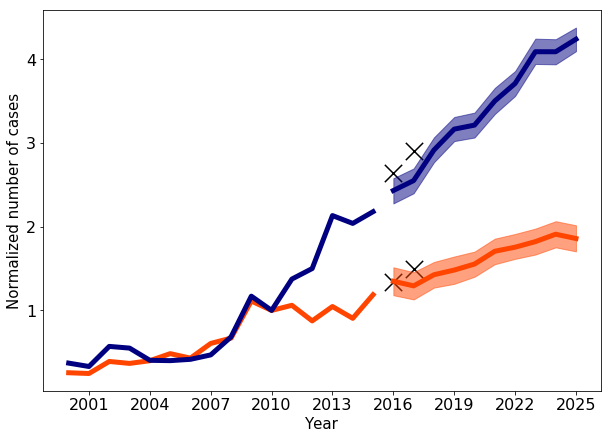

In [289]:
ax =  plt.figure(facecolor='w', figsize=(10,7)).gca()
colors = ['orangered', 'red', 'navy']

for i in [0,2]: 
    model = models[i]
    data = datas[i]
    test = futures[i]
    fcst = model.predict(test)
    
    total_years = data.ds.dt.year.append(fcst.ds.dt.year)
    total_data = data.y.append(fcst.yhat)
    
    val_i = val_df_norms[val_df_norms['Label']==i].groupby(['year'])['Cases_norm_2010'].mean().reset_index()

    ax.plot(val_i.year[:-2],val_i.Cases_norm_2010[:-2], colors[i], linewidth=5.0)
    ax.plot(fcst.ds.dt.year,fcst.yhat, colors[i], linewidth=5.0)
    #ax.plot(total_years, total_data, colors[i], linewidth=5.0)
    ax.fill_between(fcst.ds.dt.year, fcst['yhat_lower'], fcst['yhat_upper'],
                color=colors[i], alpha=0.5)

    ax.scatter(test.ds.dt.year[0:2],test.y[0:2], color='black', marker='x', s=300, zorder=0)
    ax.set_ylabel('Normalized number of cases', size=15)
    ax.set_xlabel('Year', size=15)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
#ax.save('images/final.png', bbox_inches=extent.expanded(1.1, 1.2), dpi=200)


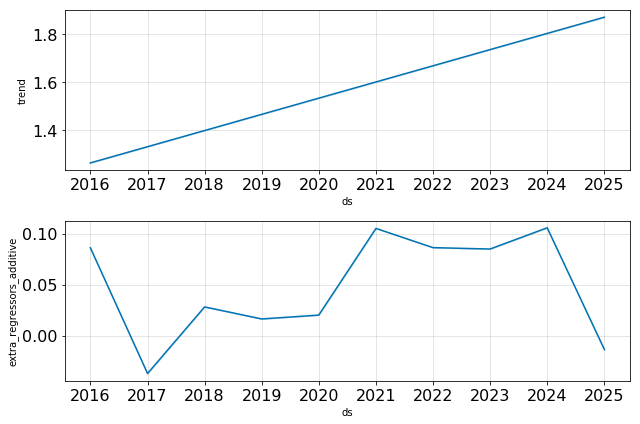

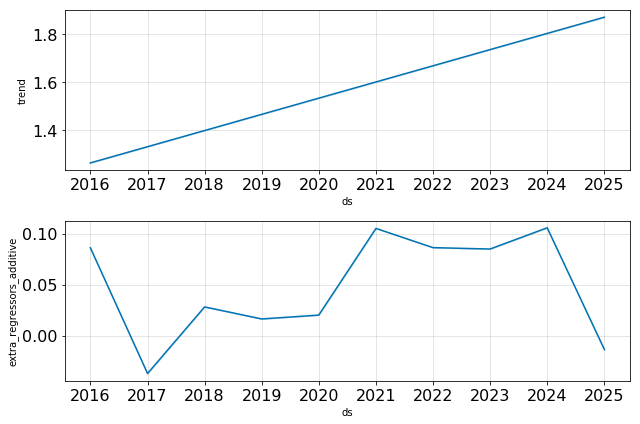

In [290]:
models[0].plot_components(fcsts[0])

In [249]:
final_df.to_csv('../data/processed/data_preds.csv')
final_df[val_df.columns].append(xval_df).to_csv('../data/processed/data_pred_all.csv')
final_df.to_csv('../app/data_preds.csv')
final_df[val_df.columns].append(xval_df).to_csv('../app/data_pred_all.csv')

In [209]:
pct_errs = [100*(x-y) for x,y in zip(baseline_errs, model_errs)]
print('Model is %2.2f, %2.2f percents better for years 1,2 than baseline for class %d ' %(pct_errs[0][0],pct_errs[0][1], 1))
print('Model is %2.2f, %2.2f percents better for years 1,2 than baseline for class %d ' %(pct_errs[1][0],pct_errs[1][1], 2))
print('Model is %2.2f, %2.2f percents better for years 1,2 than baseline for class %d ' %(pct_errs[2][0],pct_errs[2][1], 3))
print('Model is %2.2f, %2.2f percents better for years 1,2 than baseline for class %d ' %(pct_errs[3][0],pct_errs[3][1], 4))

Model is 28.89, 27.21 percents better for years 1,2 than baseline for class 1 
Model is -16.33, -16.99 percents better for years 1,2 than baseline for class 2 
Model is 18.27, 16.58 percents better for years 1,2 than baseline for class 3 
Model is -4.29, 14.83 percents better for years 1,2 than baseline for class 4 


In [361]:
baseline_errs # old 

[array([ 0.30827759,  0.38296931]),
 array([ 0.12470612,  0.14800951]),
 array([ 0.0014843 ,  0.24378572]),
 array([ 0.18718938,  0.26302498])]

In [283]:
model_errs # old 

[array([ 0.05752116,  0.10802511]),
 array([ 0.26746945,  0.06598048]),
 array([ 0.22156055,  0.41436035]),
 array([ 0.00167071,  0.08524429])]

In [317]:
# cols = ['CTYCODE', 'Cases_new', 'Ctyname', 'FIPS',  'Pred', 'STCODE', 'Stname', 'TOT_POP',
#        'counties', 'geometry', 'lat', 'long', 'year', 'Cases_lower','Cases_upper']
# t1 = val_df.drop(val_df[(val_df.year>=2006)].index)[['CTYCODE', 'Cases_new', 'Ctyname', 'FIPS',  'STCODE', 'Stname', 'TOT_POP',
#        'counties', 'geometry', 'lat', 'long', 'year']]
# t1['Pred']=0
# t1['Cases_upper']=0
# t1['Cases_lower']=0
# t2 = final_df[cols][cols]
# t1.append(t2).to_csv('../data/processed/data_preds.csv')

/Users/avani/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




## Plot the models and predictions 

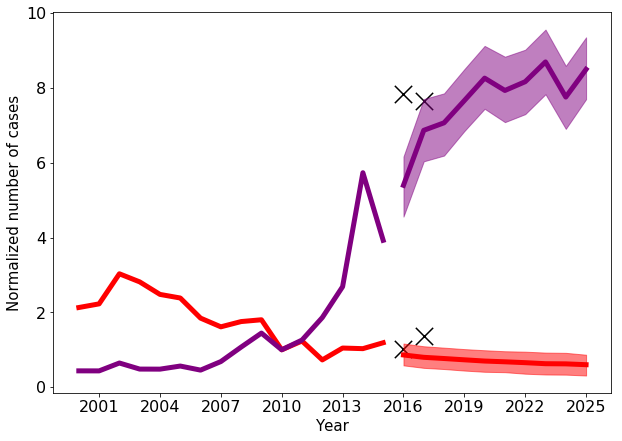

In [217]:
ax =  plt.figure(facecolor='w', figsize=(10,7)).gca()
colors = ['orangered', 'red', 'navy', 'purple']

for i in [1,3]: 
    model = models[i]
    data = datas[i]
    test = futures[i]
    fcst = model.predict(test)
    
    total_years = data.ds.dt.year.append(fcst.ds.dt.year)
    total_data = data.y.append(fcst.yhat)
    
    val_i = val_df_norms[val_df_norms['Label']==i].groupby(['year'])['Cases_norm_2010'].mean().reset_index()

    ax.plot(val_i.year[:-2],val_i.Cases_norm_2010[:-2], colors[i], linewidth=5.0)
    ax.plot(fcst.ds.dt.year,fcst.yhat, colors[i], linewidth=5.0)
    #ax.plot(total_years, total_data, colors[i], linewidth=5.0)
    ax.fill_between(fcst.ds.dt.year, fcst['yhat_lower'], fcst['yhat_upper'],
                color=colors[i], alpha=0.5)

    ax.scatter(test.ds.dt.year[0:2],test.y[0:2], color='black', marker='x', s=300, zorder=0)
    ax.set_ylabel('Normalized number of cases', size=15)
    ax.set_xlabel('Year', size=15)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
#ax.save('images/final.png', bbox_inches=extent.expanded(1.1, 1.2), dpi=200)


## County-by county predictions 


In [56]:
final_df_individual = val_df.copy()
allfips = val_df.FIPS.unique()
    
mostfips = fips_classes[0].append(fips_classes[-1])

# xx = [list(x) for x in fips_classes]
# mostfips = [item for sublist in xx for item in sublist]

climfips = list(clim_proj_all.FIPS.unique())

for fip in list(mostfips): 
    
    if fip in climfips: 

        val_i = val_df[val_df['FIPS']==fip][['Cases_new', 'year']]
        clim_i_all = clim_proj_all[clim_proj_all['FIPS']==fip][['year', 'tavg', 'tmax', 'tmin', 'pcpn']]
        val_i = val_i.drop(val_i[(val_i.year<2006)].index).merge(clim_i_all, how='outer')
        val_i.columns = ['y', 'ds', 'tavg', 'tmax', 'tmin', 'pcpn']
        val_i = val_i[['ds', 'y', 'tavg','pcpn']]

        lastyear = max(val_df[val_df['FIPS']==fip].year.unique())-2

        # create train, test set 

        train, test = create_test_train_data(val_i, lastyear)

        # run forecast 

        fcst, m0 = run_prophet(train, test)
        fcs = clean_forecast(fcst)

        val_i['Pred'] = 0 
        val_pred_i = val_i.merge(fcs, how='left', left_on='ds', right_on='year').drop('year', axis=1)
        val_pred_i.Cases_new.fillna(val_pred_i.y, inplace=True)
        val_pred_i.Cases_upper.fillna(0.0, inplace=True)
        val_pred_i.Cases_lower.fillna(0.0, inplace=True)
        val_pred_i['Pred'] = 0 
        mask = val_pred_i['ds']>=lastyear
        val_pred_i['Pred'][mask] = 2

        temp_row = val_df[val_df.FIPS==fip].iloc[0].copy()
        new_cols = val_pred_i[val_pred_i['ds'] >= lastyear].drop('y', axis=1).copy()

        tempdf = pd.DataFrame()

        for i in range(len(new_cols)):
            temp_row['Cases_new'] = new_cols['Cases_new'].iloc[i]
            temp_row['year'] = new_cols['ds'].iloc[i]
            temp_row['Cases_upper'] = new_cols['Cases_upper'].iloc[i]
            temp_row['Cases_lower'] = new_cols['Cases_lower'].iloc[i]
            temp_row['tavg'] = new_cols['tavg'].iloc[i]
            temp_row['tmax'] = new_cols['tmax'].iloc[i]
            temp_row['tmin'] = new_cols['tmin'].iloc[i]
            temp_row['pcpn'] = new_cols['pcpn'].iloc[i] 
            temp_row['Pred'] = new_cols['Pred'].iloc[i]
            tempdf = tempdf.append(temp_row)

        final_df_individual = final_df_individual.append(tempdf)

/Users/avani/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/Dropbox/Work/dataScience/Insight/PredictLyme/notebooks/utils.py:138: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
final_df_individual.to_csv('../data/processed/data_pred_indi.csv')

## Preparing data for HTS 

In [296]:
def classify_fips(fip, fips_classes): 
    for i in range(4):
        if fip in list(fips_classes[i]):
            return i+1
    return -1 

In [553]:
val_df_2['label'] = val_df_2['FIPS'].apply(lambda x : classify_fips(x, fips_classes)) 
val3 = val_df_2[['year','label', 'FIPS',  'Cases']]
val3.columns = ['Date', 'label' , 'FIPS', 'Cases']

val4 = val3[['Date', 'Cases']].groupby('Date').sum().reset_index()

for i in range(1,5):
    temp = val3[val3['label']==i][['Date', 'Cases']]
    temp = temp.groupby('Date').sum().reset_index()
    temp.columns = ['Date', 'label'+str(i)]
    val4 = val4.merge(temp)
    
for i in range(4):
    fips = fips_classes[i]
    for fip in list(fips):
        temp = val3[val3['FIPS']==fip][['Date', 'Cases']]
        temp = temp.groupby('Date').sum().reset_index()
        temp.columns = ['Date', str(fip)]
        val4 = val4.merge(temp)
        
        
val4.Date = pd.to_datetime((val4.Date),format='%Y')
val4.to_csv('val4.csv', index=False)